## 1 Analysing MNIST

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist_data = mnist.data
mnist_targets = mnist.target

### PCA

In [3]:
def sort_evals_descending(evals, evectors):
    """
    Sorts eigenvalues and eigenvectors in decreasing order. This function
    also aligns the first two eigenvectors to be in first two quadrants if
    the data is 2D (remember that any eigenvector's direction can be inverted
    and it is still an eigenvector with the same eigenvalue). 
    """

    index = np.flip(np.argsort(evals))
    evals = evals[index]
    evectors = evectors[:, index]
    if evals.shape[0] == 2:
        if np.arccos(np.matmul(evectors[:, 0], 1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
            evectors[:, 0] = -evectors[:, 0]
        if np.arccos(np.matmul(evectors[:, 1], 1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
            evectors[:, 1] = -evectors[:, 1]
    return evals, evectors
    
def pca(X):
    """
    Performs PCA on multivariate data.

    Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

    Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : eigenvectors
    (numpy array of floats)   : corresponding eigenvalues

    """

    # Subtract the mean of X
    X_bar = X - np.mean(X, axis=0)
    # Calculate the sample covariance matrix
    cov_matrix = (1 / X.shape[0]) * np.matmul(X_bar.T, X_bar)
    # Calculate the eigenvalues and eigenvectors
    evals, evectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues in descending order
    evals, evectors = sort_evals_descending(evals, evectors)
    # Project the data onto the new eigenvector basis
    score = np.matmul(X, evectors)

    return score, evectors, evals, cov_matrix


score, evecs, evals, cm = pca(mnist_data)
evecs = evecs.T

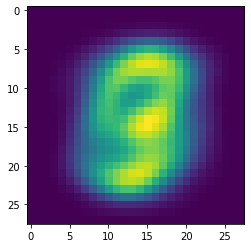

334289.2857891296
245429.92095245735
0.0974611592249476
0.07155444586878701


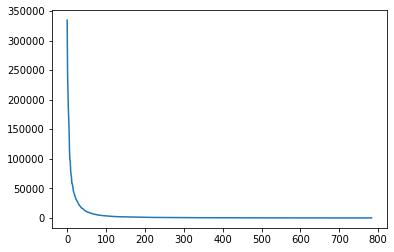

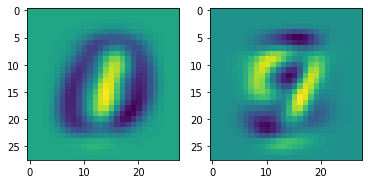

In [4]:
fig, ax = plt.subplots()
ax.imshow(np.reshape(np.mean(mnist_data, axis=0), (28,28)))
plt.show()

print(np.matmul(np.matmul(evecs[0], cm),evecs[0].T))
print(np.matmul(np.matmul(evecs[1], cm),evecs[1].T))

cv = []
cvsum = 0
for i in range(784):
    cv.append(np.matmul(np.matmul(evecs[i], cm),evecs[i].T))
    cvsum += np.matmul(np.matmul(evecs[i], cm),evecs[i].T)

print(np.matmul(np.matmul(evecs[0], cm),evecs[0].T)/cvsum)
print(np.matmul(np.matmul(evecs[1], cm),evecs[1].T)/cvsum)

fig, ax = plt.subplots()
ax.plot(np.arange(784), cv)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(np.reshape(evecs[0], (28,28)))
ax2.imshow(np.reshape(evecs[1], (28,28)))
plt.show()

### K-means

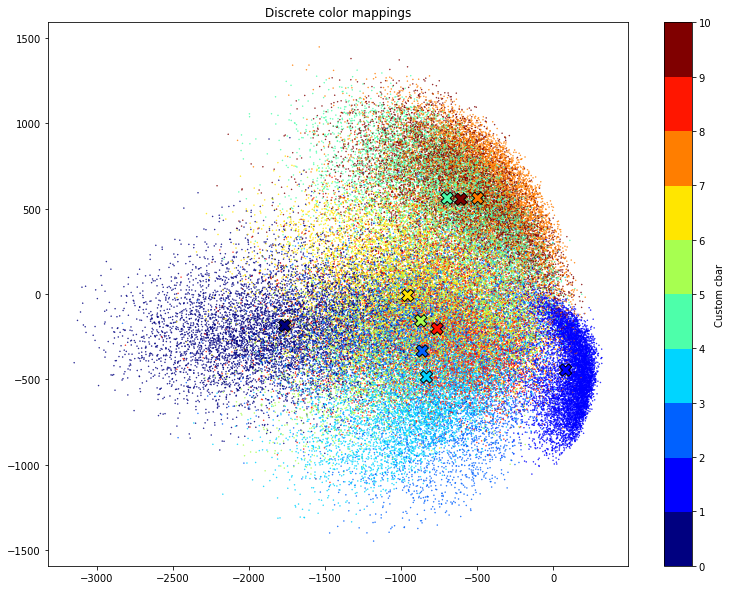

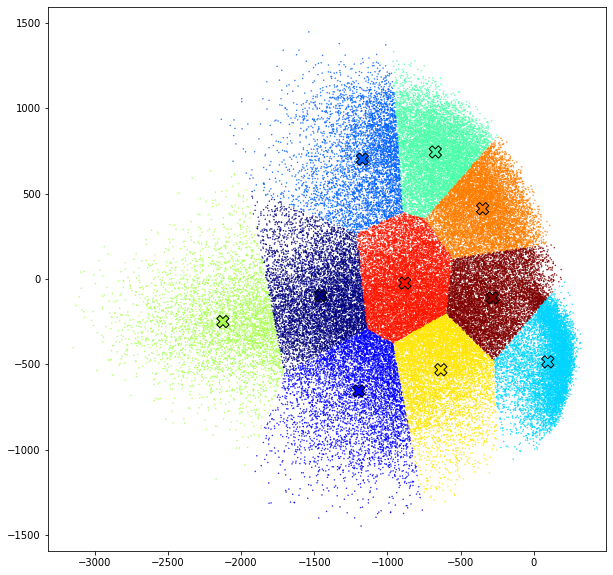

In [6]:
from sklearn.cluster import KMeans

score = np.matmul(mnist_data, evecs[:2].T)
mnist_targets = list(map(int, mnist_targets))
centers = np.zeros((10,2))
count = np.zeros((10,))

for i, item in enumerate(score):
    centers[mnist_targets[i]] += item
    count[mnist_targets[i]] += 1

for i, item in enumerate(centers):
    item/= count[i]

N=10 # num labels

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#make scatter
fig, ax = plt.subplots(figsize=(13,10))
scat = ax.scatter(score.T[0], score.T[1], c=mnist_targets, s=0.2, cmap = cmap, norm=norm)
ax.scatter(centers.T[0], centers.T[1], marker='X', c=np.arange(10), cmap=cmap, s=150, edgecolors='k')
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Custom cbar')
ax.set_title('Discrete color mappings')
plt.show()

def plot_k_means(X, cluster_assignments, centroid_locations):
    plt.figure(figsize=(10, 10))
    plt.viridis() # Set colour map
    plt.scatter(X[:, 0], X[:, 1], s=0.2, c=cluster_assignments, cmap = cmap, norm=norm) # plot data points
    plt.scatter(centroid_locations[:, 0], centroid_locations[:, 1], s=150, cmap = cmap, marker='X', c=range(N), edgecolors='k') # plot centroids
    plt.show()

kmeans = KMeans(10, init='random').fit(score)
cluster_assignments = kmeans.predict(score)
centroid_locations = kmeans.cluster_centers_

plot_k_means(score, cluster_assignments, centroid_locations)

## Classifiers

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist_data, mnist_targets, test_size=0.1)
X_train = X_train/255
X_test = X_test/255

### ANNs

(63000, 784)


Text(0, 0.5, 'Loss')

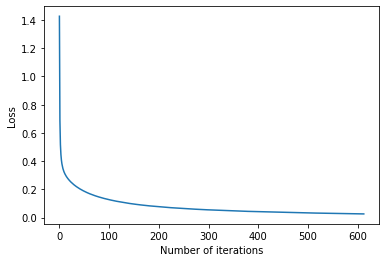

In [13]:
print(X_train.shape)


nn_clf = MLPClassifier(hidden_layer_sizes=(70),
                    activation='relu',
                    solver='sgd',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1)
nn_clf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nn_clf.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')



In [16]:
print(nn_clf.score(X_test, y_test))
print(nn_clf.score(X_train, y_train))

0.9718571428571429
0.9951904761904762


In [ ]:
alphas = np.logspace(-3, -0, 100)
learning_rates = np.logspace(-4, -2, 100)
parameters = {'learning_rate_init':learning_rates, 'alpha':alphas}

nn = MLPClassifier(hidden_layer_sizes=(70),
                    activation='relu',
                    solver='sgd',
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1)

clf = RandomizedSearchCV(nn, parameters, scoring='accuracy', n_iter=10, cv=3, verbose=2)

clf.fit(X_train, y_train)
clf.best_params_

### SVMs

In [5]:
svm = SVC(C=4)
svm.fit(X_train, y_train)

SVC(C=4)

In [6]:
print(svm.score(X_test, y_test))
print(svm.score(X_train, y_train))

0.984
0.9988095238095238


## Bayesian linear regression with PyMC3

## Building an ensemble

### Random Forest

### Stacking